<span class="label label-default" style="background-color:#47A8EC; border-radius:6px; font-weight: bold; font-family:Verdana; font-size:28px; color:#FBFAFC; ">⚡ AQI time series analysis and forecasting ⚡</span>

### **Step1: Importing the libraries**


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

### **Step2: Loading the data**

In [3]:
# Loading the dataset
df = pd.read_csv("../2. JSON to CSV/aqi_dataset.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

### **Step3: Analysing the data**

Seasonal Pattern: There are visible recurring peaks and troughs, indicating potential seasonal trends in AQI levels, especially during certain times of the year (possibly winters showing higher AQI).

Early Dip: AQI values drop sharply in early 2019, which could be due to lockdown or other external factors (like pandemic restrictions).

Increasing Variability: From 2021 onwards, there appears to be increased fluctuations, with more extreme AQI values at certain points.

Recent Decline: Towards the end of the time series (late 2024–2025), there’s a visible decline in AQI, which might indicate improved air quality or policy interventions.

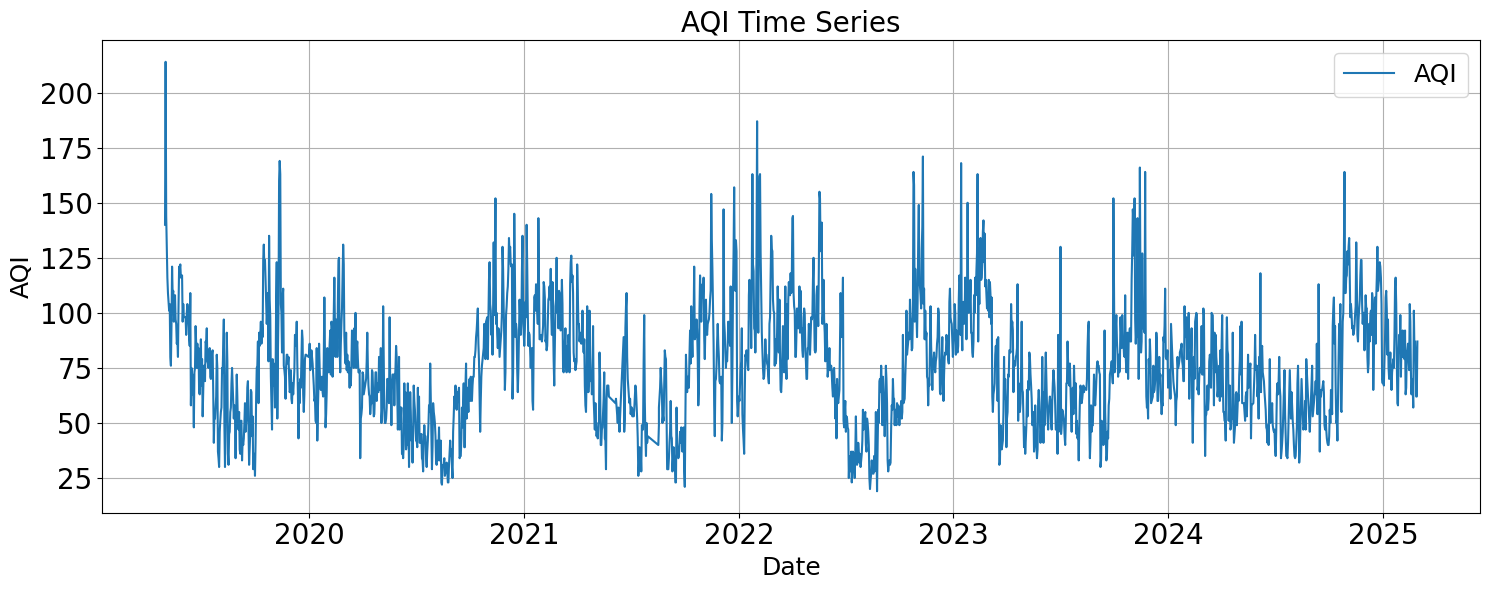

In [4]:
# Plot AQI over time
plt.figure(figsize=(15, 6))
plt.plot(df['AQI'], label='AQI')
plt.title('AQI Time Series', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('AQI', fontsize=18)
plt.legend(fontsize=18)

# Increase tick label font size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.grid(True)
plt.tight_layout()
plt.show()


From Histogram we can see that our AQI values are skewed. So log transformation can help us.

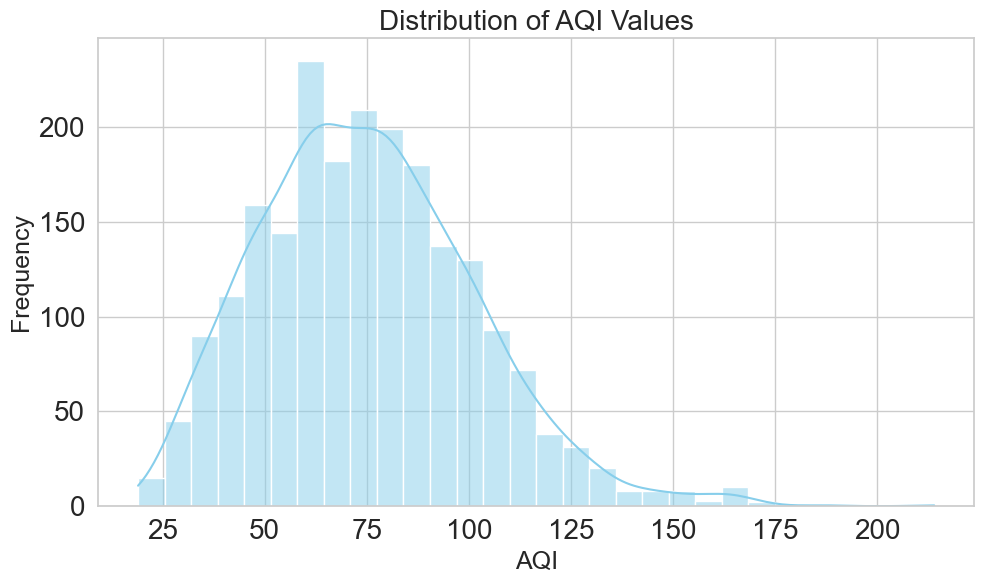

In [169]:
# Set plot style
sns.set(style="whitegrid")

# Histogram + KDE
plt.figure(figsize=(10, 6))
sns.histplot(df['AQI'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of AQI Values', fontsize=20)
plt.xlabel('AQI', fontsize=18)
plt.ylabel('Frequency', fontsize=18)

# Increase tick label font size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.tight_layout()
plt.show()

## **Step4: Distributional view of data**

We attempted to fit both the Normal and Cauchy distributions to our AQI data. From the plot below, it is evident that the Cauchy distribution does not fit the data well. While the Normal distribution provides a closer fit, it still does not perfectly capture the shape of the AQI distribution. So we are unable to determine the underlying distribution. If stationarity achieved so it will be weak stationarity as distribution is unknown.

Normal Distribution: mu=75.12435476302205, std=26.41754076124926


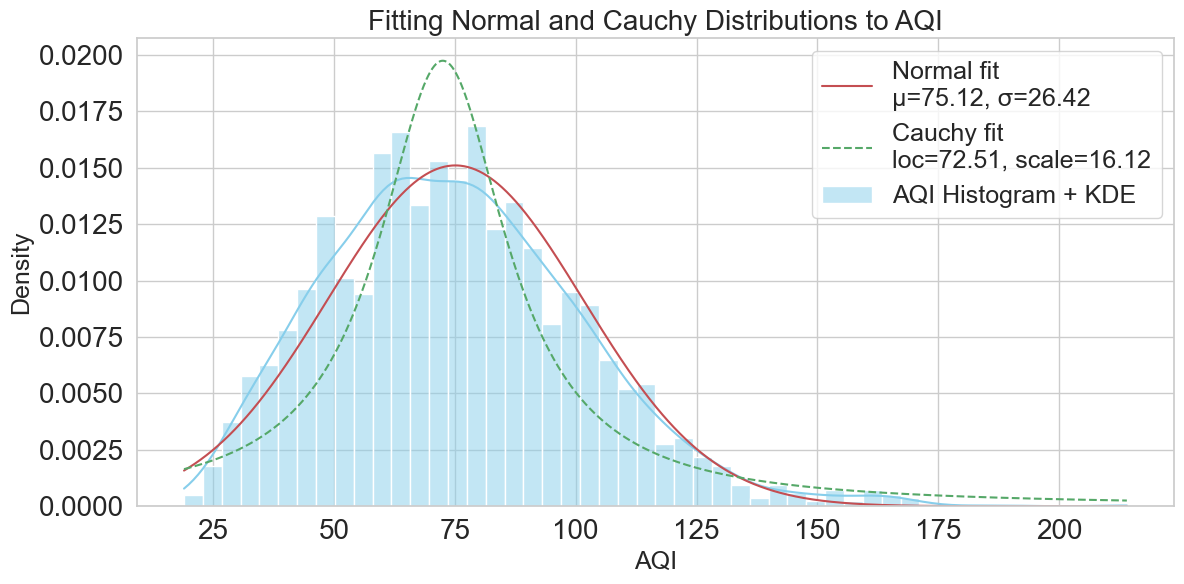

In [170]:
from scipy.stats import norm, cauchy

aqi = df['AQI']

# Fitting normal and cauchy distributions
mu_norm, std_norm = norm.fit(aqi)
loc_cauchy, scale_cauchy = cauchy.fit(aqi)

print(f"Normal Distribution: mu={mu_norm}, std={std_norm}")

# Generating x values for PDFs
x = np.linspace(aqi.min(), aqi.max(), 1000)
pdf_norm = norm.pdf(x, mu_norm, std_norm)
pdf_cauchy = cauchy.pdf(x, loc_cauchy, scale_cauchy)

# Plot histogram + KDE
plt.figure(figsize=(12, 6))

# Histogram with KDE
sns.histplot(aqi, bins=50, kde=True, stat="density", color='skyblue', alpha=0.5, label="AQI Histogram + KDE")

# Overlay PDFs
plt.plot(x, pdf_norm, 'r-', label=f'Normal fit\nμ={mu_norm:.2f}, σ={std_norm:.2f}')
plt.plot(x, pdf_cauchy, 'g--', label=f'Cauchy fit\nloc={loc_cauchy:.2f}, scale={scale_cauchy:.2f}')

# Styling
plt.title('Fitting Normal and Cauchy Distributions to AQI', fontsize=20)
plt.xlabel('AQI', fontsize=18)
plt.ylabel('Density', fontsize=18)

# Increase tick label font size
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.show()

## **Step5: Decompostion of the data(Trend, seasonality, residuals)**

Additive Decomposition (Top Plot):
->Seasonal component has a constant amplitude (height of the peaks and troughs stays roughly the same) over time.

This implies that:

AQI = Trend + Seasonal + Residual

Multiplicative Decomposition (Bottom Plot):
->Seasonal component changes proportionally with the level of the series meaning the peaks and troughs of the seasonal component become larger when the AQI values are higher.

->Seasonality appears scaled with the trend.

This implies that:

AQI = Trend × Seasonal × Residual

Reason of plotting this both plots is to just see the nature of trend(linear/non-linear) and sesonality(period) of the series if any.

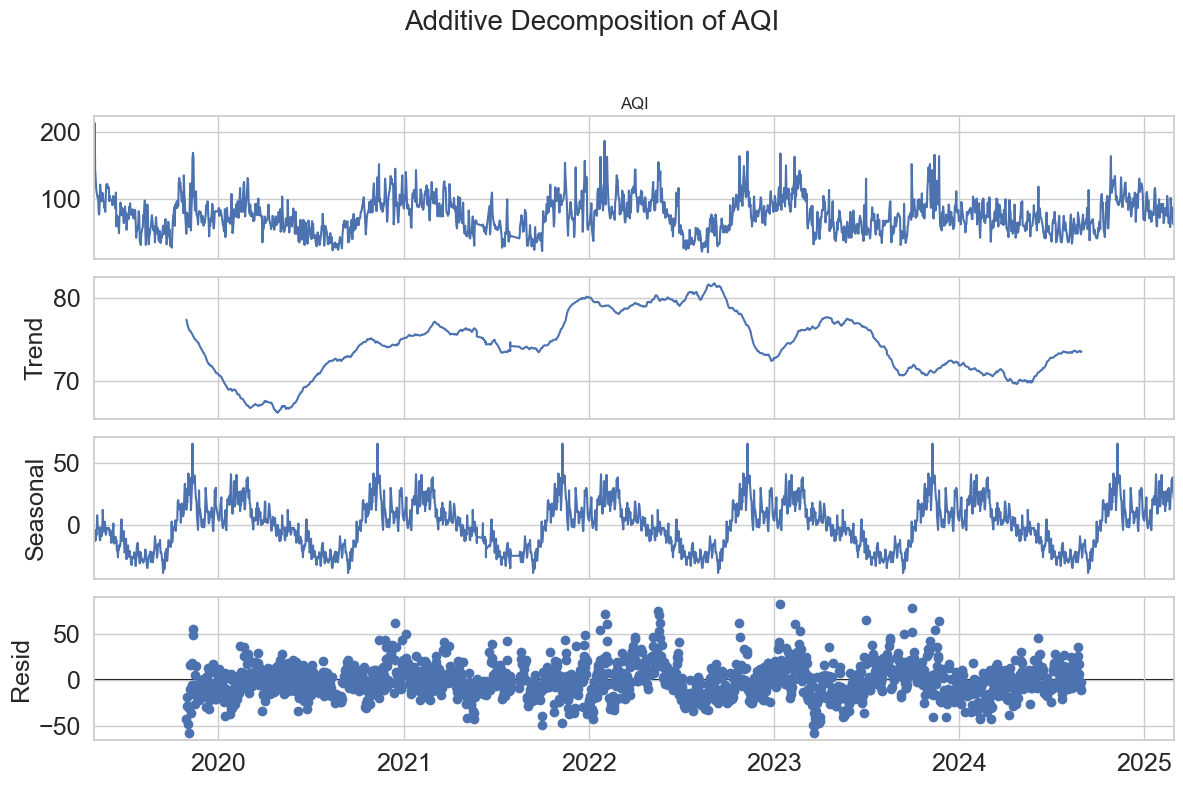

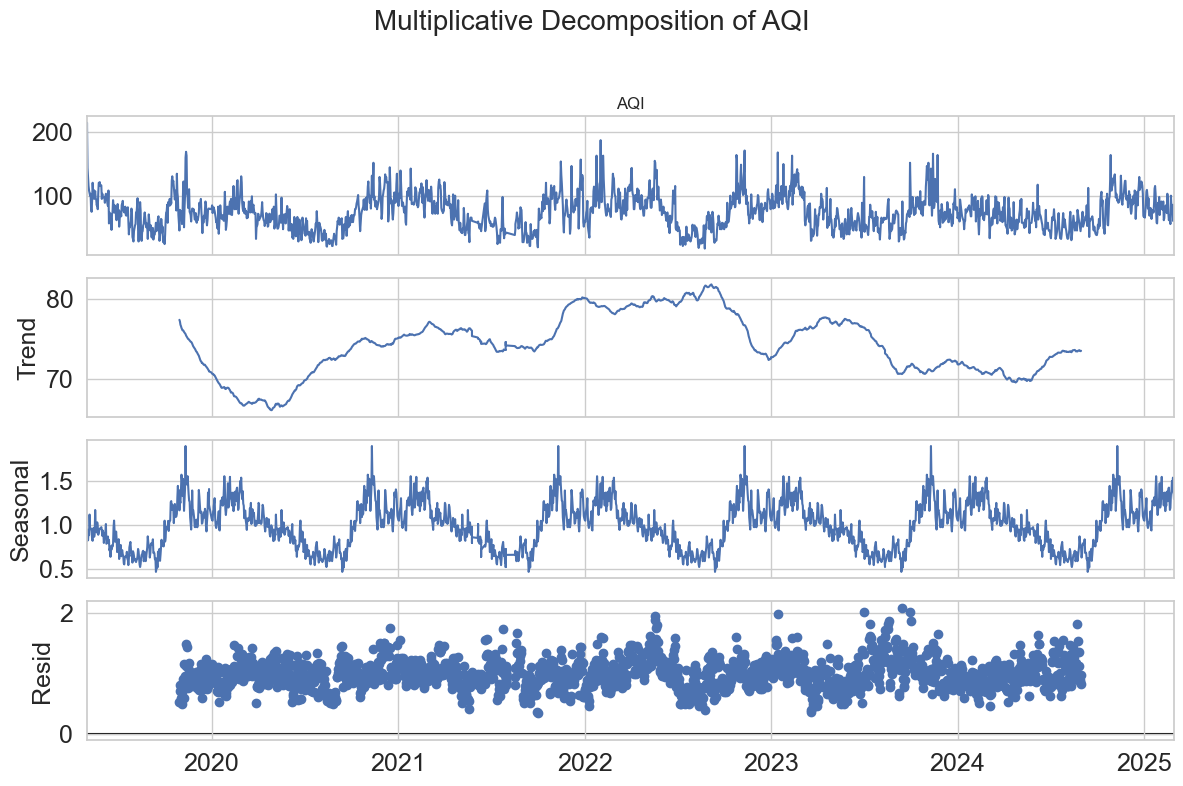

In [171]:
# --- ADDITIVE DECOMPOSITION ---
result_add = seasonal_decompose(df['AQI'], model='additive', period=365)
fig = result_add.plot()
fig.set_size_inches(12, 8)
fig.suptitle('Additive Decomposition of AQI', fontsize=20)

# Customizing tick label size
for ax in fig.axes:
    ax.tick_params(axis='both', labelsize=18) 
    ax.set_ylabel(ax.get_ylabel(), fontsize=18) 

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# --- MULTIPLICATIVE DECOMPOSITION ---
result_mult = seasonal_decompose(df['AQI'], model='multiplicative', period=365)
fig = result_mult.plot()
fig.set_size_inches(12, 8)
fig.suptitle('Multiplicative Decomposition of AQI', fontsize=20)

# Customizing tick label size
for ax in fig.axes:
    ax.tick_params(axis='both', labelsize=18)
    ax.set_ylabel(ax.get_ylabel(), fontsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## **Step6: Stationarity checking**

A time series is stationary if its mean, variance, and autocorrelation (ACF) remain constant over time.

Mean: Should not show upward or downward trends(constant across series).

Variance: Should remain stable across the series.

ACF: Should drop off quickly if the series is stationary(should depend only on the lag paramter not on the time).

If these properties change over time, the series is non-stationary and needs transformations like differencing or log transformation to stabilize it.

And we used a rolling window of 30 days because our AQI data is on a daily scale, and a 30-day window helps us capture broader monthly trends while smoothing out short-term fluctuations. In air quality studies, 30-day windows are often used because monthly patterns (festivals, weather cycles, crop burning) affect AQI. This makes it easier to analyze seasonal variations and check for consistency or changes in the mean and variance over time. A 7-day window would be too sensitive to weekly changes it might catch short-term noise rather than meaningful trends. On the other hand, a 60-day window would smooth the data too much and potentially hide important month-wise patterns. So, 30 days is a balanced choice long enough to reduce noise, but short enough to capture meaningful variation in AQI on a monthly basis.

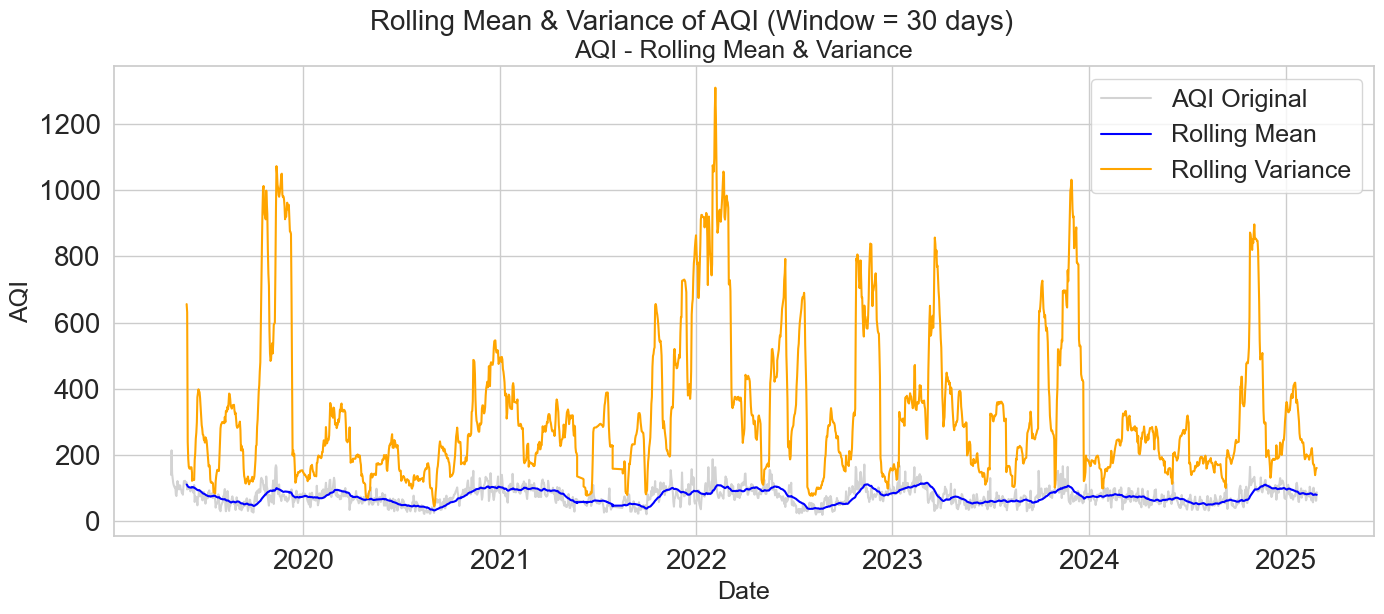

In [172]:
# Plotting mean and variance of AQI
window = 30  # rolling window size in days

plt.figure(figsize=(14, 6))
plt.plot(df['AQI'], label=f'{'AQI'} Original', color='lightgray')
plt.plot(df['AQI'].rolling(window).mean(), label='Rolling Mean', color='blue')
plt.plot(df['AQI'].rolling(window).var(), label='Rolling Variance', color='orange')
plt.title(f'{'AQI'} - Rolling Mean & Variance', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.xticks(fontsize=20)
plt.ylabel('AQI', fontsize=18)
plt.yticks(fontsize=20)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()

plt.suptitle('Rolling Mean & Variance of AQI (Window = 30 days)', fontsize=20, y=1.02)
plt.show()


## **Step7: Data transformation**

Since our series is skewed and also the variance have huge fluctuations so we will take a log transformation on it. And then check for stationarity, if not yet so we will then use methods like

-Linear regression(helps in linear trend only)

-MA method

-Differencing method

In our case we will use differencing method. We then again check for stationarity using mean, variance and ACF.

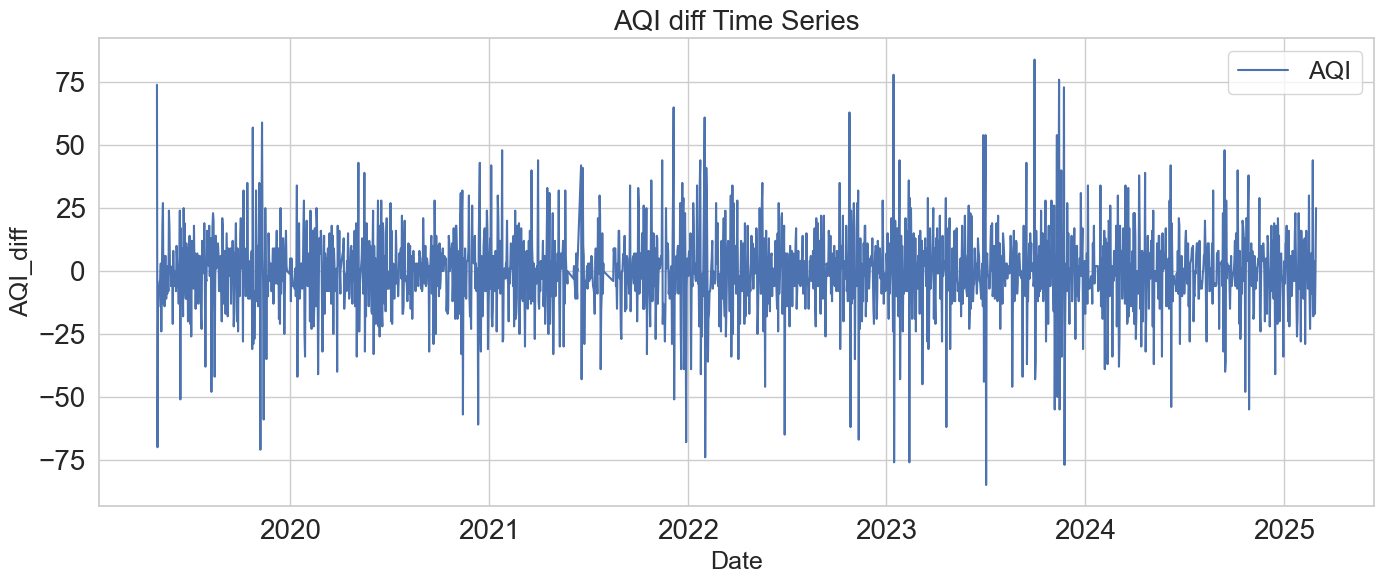

In [173]:
df['AQI_diff'] = df['AQI'].diff()

# Plot AQI difference over time
plt.figure(figsize=(14, 6))
plt.plot(df['AQI_diff'], label='AQI')
plt.title('AQI diff Time Series', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.xticks(fontsize=20)
plt.ylabel('AQI_diff', fontsize=18)
plt.yticks(fontsize=20)
plt.grid(True)
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()

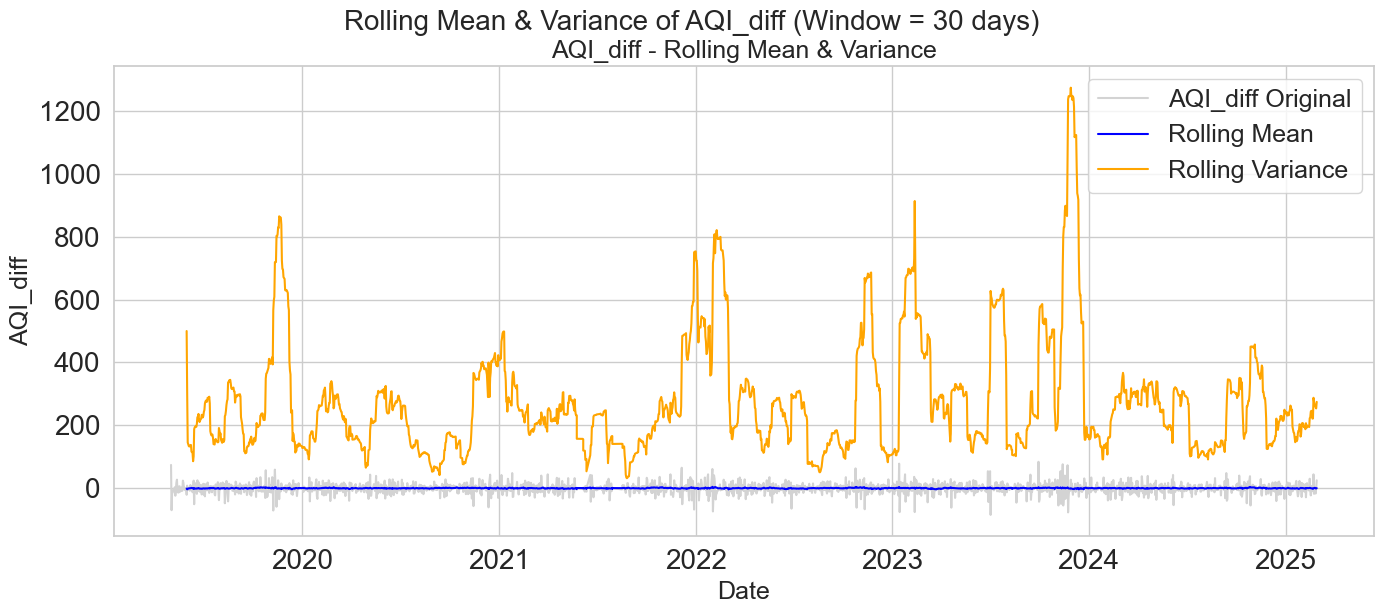

In [174]:
# Plotting mean and variance of AQI difference
window = 30  # rolling window size in days

plt.figure(figsize=(14, 6))
plt.plot(df['AQI_diff'], label=f'{'AQI_diff'} Original', color='lightgray')
plt.plot(df['AQI_diff'].rolling(window).mean(), label='Rolling Mean', color='blue')
plt.plot(df['AQI_diff'].rolling(window).var(), label='Rolling Variance', color='orange')
plt.title(f'{'AQI_diff'} - Rolling Mean & Variance', fontsize=18)
plt.xlabel('Date', fontsize=18)
plt.xticks(fontsize=20)
plt.ylabel('AQI_diff', fontsize=18)
plt.yticks(fontsize=20)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()

plt.suptitle('Rolling Mean & Variance of AQI_diff (Window = 30 days)', fontsize=20, y=1.02)
plt.show()

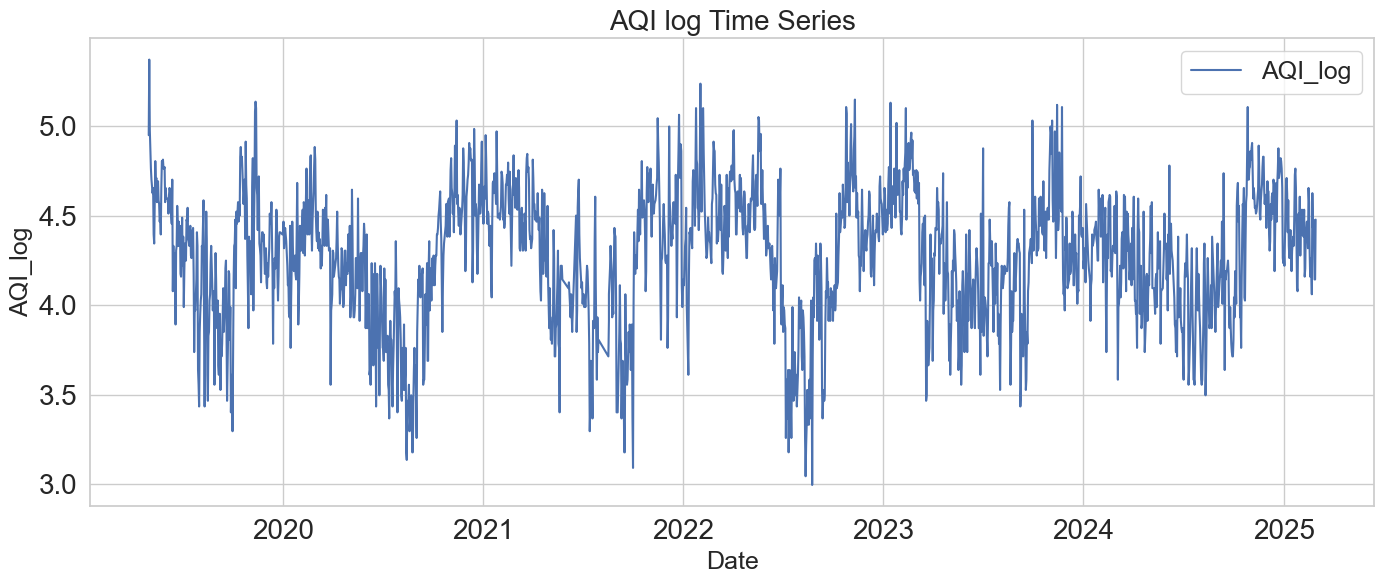

In [175]:
df['AQI_log'] = np.log(df['AQI'] + 1)  # Adding 1 to avoid log(0)

# Plot AQI log over time
plt.figure(figsize=(14, 6))
plt.plot(df['AQI_log'], label='AQI_log')
plt.title('AQI log Time Series', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.xticks(fontsize=20)
plt.ylabel('AQI_log', fontsize=18)
plt.yticks(fontsize=20)
plt.grid(True)
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()

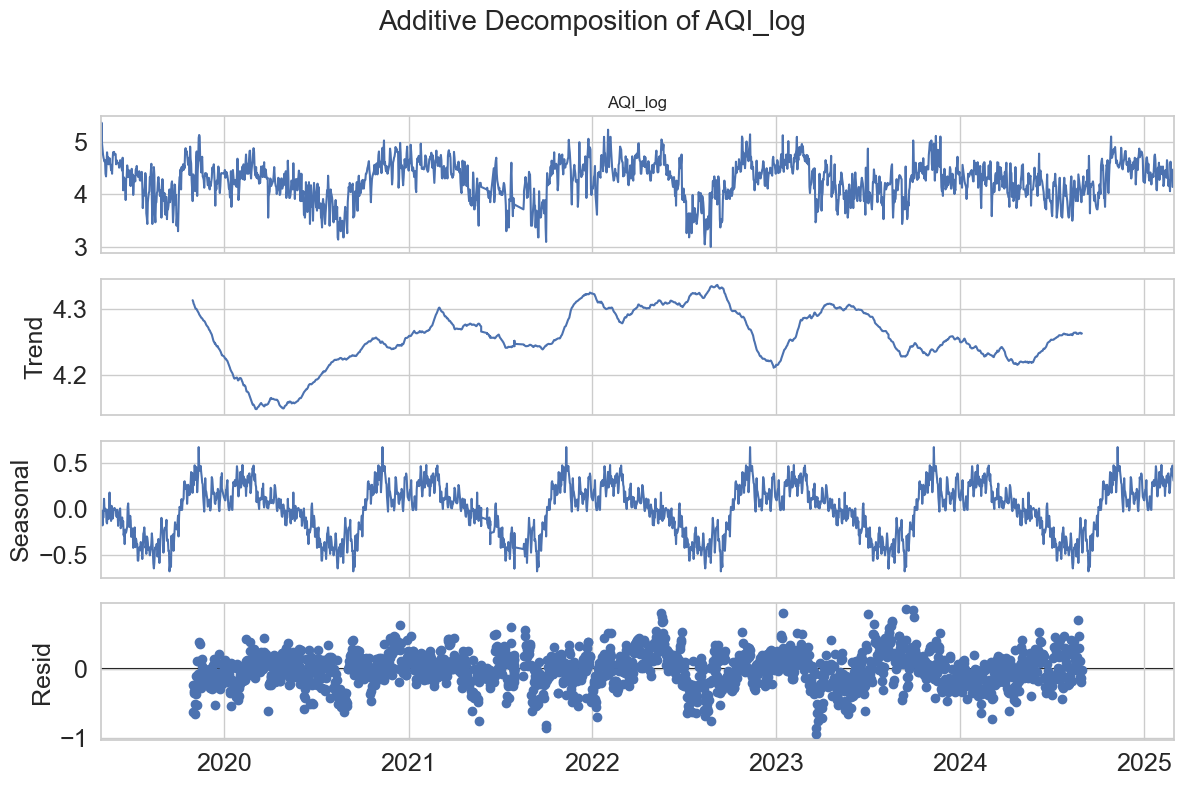

In [176]:
# --- ADDITIVE DECOMPOSITION ---
result_add = seasonal_decompose(df['AQI_log'], model='additive', period=365)
fig = result_add.plot()
fig.set_size_inches(12, 8)
fig.suptitle('Additive Decomposition of AQI_log', fontsize=20)

# Customizing tick label size
for ax in fig.axes:
    ax.tick_params(axis='both', labelsize=18) 
    ax.set_ylabel(ax.get_ylabel(), fontsize=18) 

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

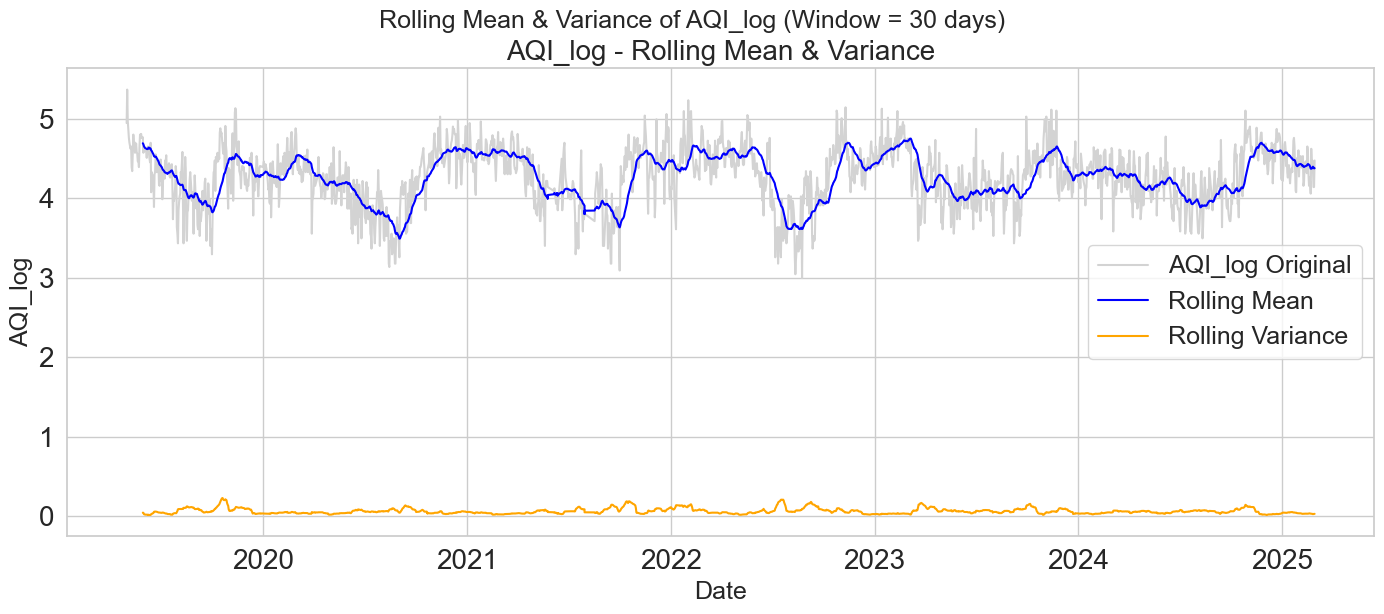

In [177]:
# Plotting mean and variance of AQI log
window = 30  # rolling window size in days

plt.figure(figsize=(14, 6))
plt.plot(df['AQI_log'], label=f'{'AQI_log'} Original', color='lightgray')
plt.plot(df['AQI_log'].rolling(window).mean(), label='Rolling Mean', color='blue')
plt.plot(df['AQI_log'].rolling(window).var(), label='Rolling Variance', color='orange')
plt.title(f'{'AQI_log'} - Rolling Mean & Variance', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('AQI_log', fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()

plt.suptitle('Rolling Mean & Variance of AQI_log (Window = 30 days)', fontsize=18, y=1.02)
plt.show()


## **Step8: Differencing Method used to make stationary data**

In [178]:
# Taking difference of the log-transformed AQI
df['AQI_log_diff'] = df['AQI_log'].diff()

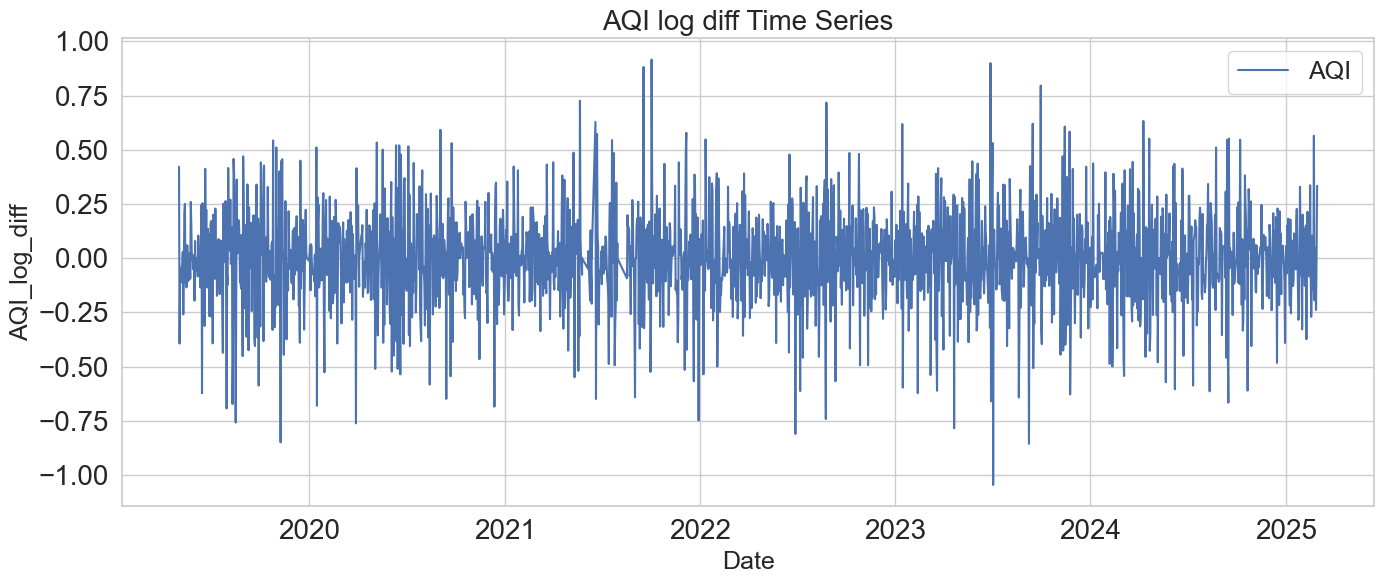

In [179]:
# Plot AQI log difference over time
plt.figure(figsize=(14, 6))
plt.plot(df['AQI_log_diff'], label='AQI')
plt.title('AQI log diff Time Series', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.xticks(fontsize=20)
plt.ylabel('AQI_log_diff', fontsize=18)
plt.yticks(fontsize=20)
plt.grid(True)
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()

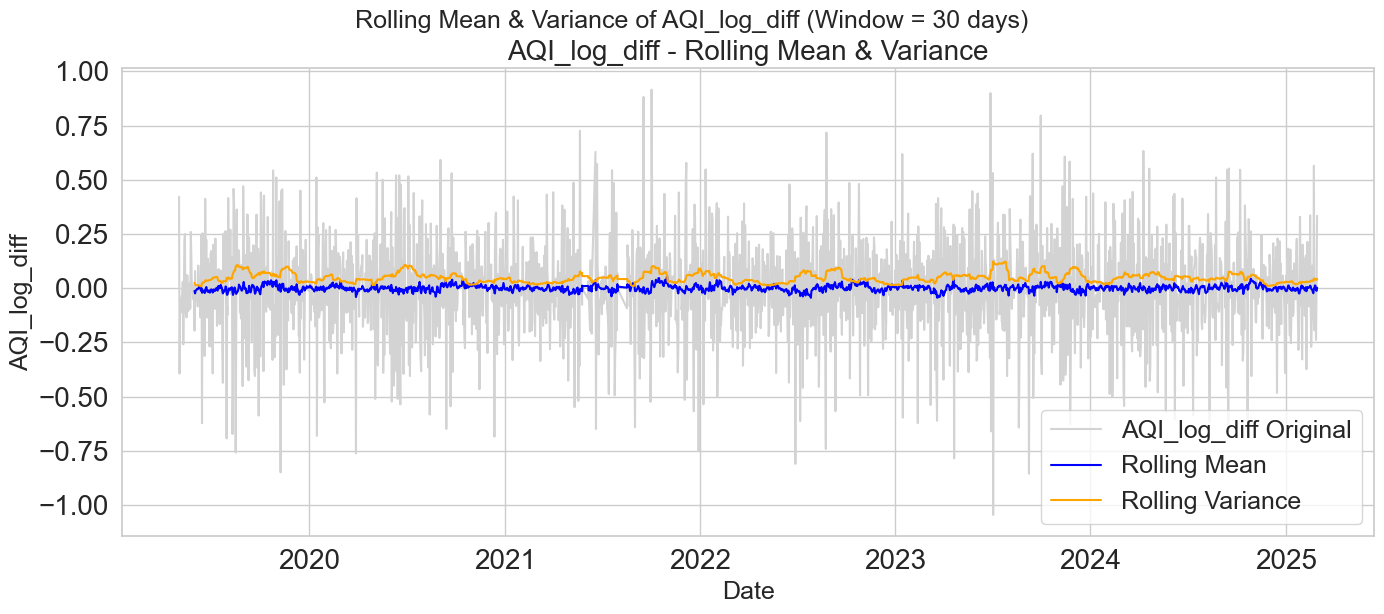

In [180]:
# Plotting mean and variance of AQI log difference
window = 30  # rolling window size in days

plt.figure(figsize=(14, 6))
plt.plot(df['AQI_log_diff'], label=f'{'AQI_log_diff'} Original', color='lightgray')
plt.plot(df['AQI_log_diff'].rolling(window).mean(), label='Rolling Mean', color='blue')
plt.plot(df['AQI_log_diff'].rolling(window).var(), label='Rolling Variance', color='orange')
plt.title(f'{'AQI_log_diff'} - Rolling Mean & Variance', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('AQI_log_diff', fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=18)
plt.grid(True)
plt.tight_layout()

plt.suptitle('Rolling Mean & Variance of AQI_log_diff (Window = 30 days)', fontsize=18, y=1.02)
plt.show()


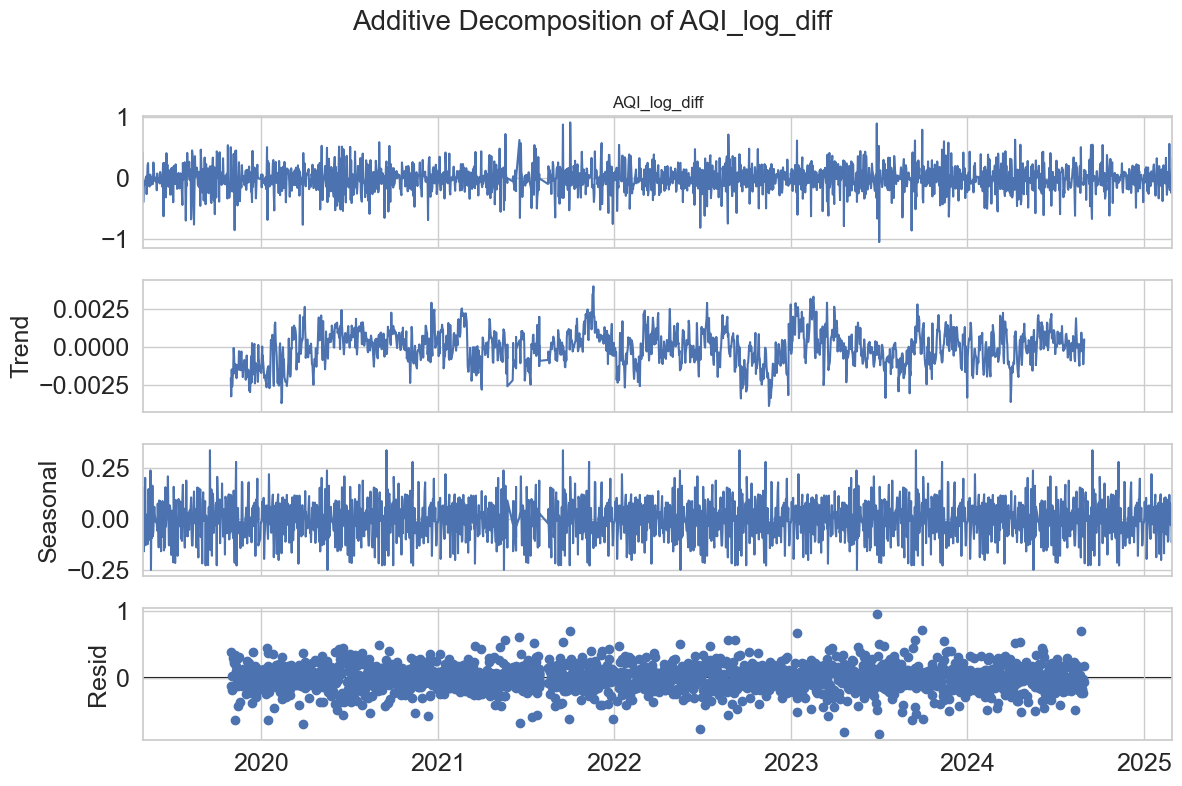

In [181]:
# --- ADDITIVE DECOMPOSITION ---
result_add = seasonal_decompose(df['AQI_log_diff'].dropna(), model='additive', period=365)
fig = result_add.plot()
fig.set_size_inches(12, 8)
fig.suptitle('Additive Decomposition of AQI_log_diff', fontsize=20)

# Customizing tick label size
for ax in fig.axes:
    ax.tick_params(axis='both', labelsize=18)
    ax.set_ylabel(ax.get_ylabel(), fontsize=18) 

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## **Step9: Plotting ACF to verify stationarity**

The ACF plot helps check stationarity by showing the correlation of the series with its past values.
If the ACF drops off quickly (i.e., few significant lags), the series is likely stationary.
If it declines slowly, the series may be non-stationary.

In the original AQI series, the ACF declines slowly, indicating non-stationarity.
In the AQI_diff series, although only a few lags are significant, the variance fluctuates, so it cannot be considered stationary.
In the AQI_log_diff series, we observe three significant lags (suggesting a possible MA(2) or MA(3) process), and both the mean and variance appear nearly constant.
Therefore, we can consider AQI_log_diff to be a stationary series.

<Figure size 1200x600 with 0 Axes>

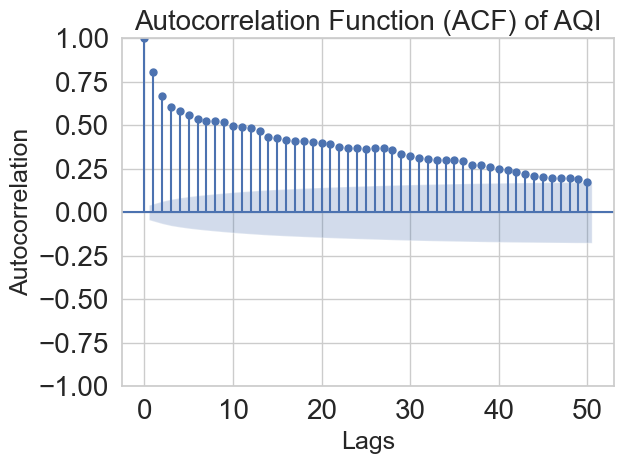

In [182]:
# ACF Plot of original AQI
plt.figure(figsize=(12, 6))
plot_acf(aqi, lags=50, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of AQI', fontsize=20)
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Autocorrelation', fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

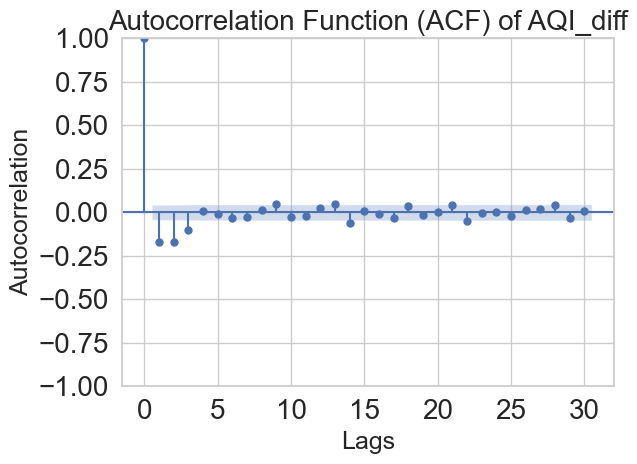

In [183]:
# Drop NaN introduced by differencing
aqi_diff = df['AQI_diff'].dropna()

# ACF Plot of AQI_diff
plt.figure(figsize=(12, 6))
plot_acf(aqi_diff, lags=30, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of AQI_diff', fontsize=20)
plt.xlabel('Lags', fontsize=18)
plt.xticks(fontsize=20)
plt.ylabel('Autocorrelation', fontsize=18)
plt.yticks(fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

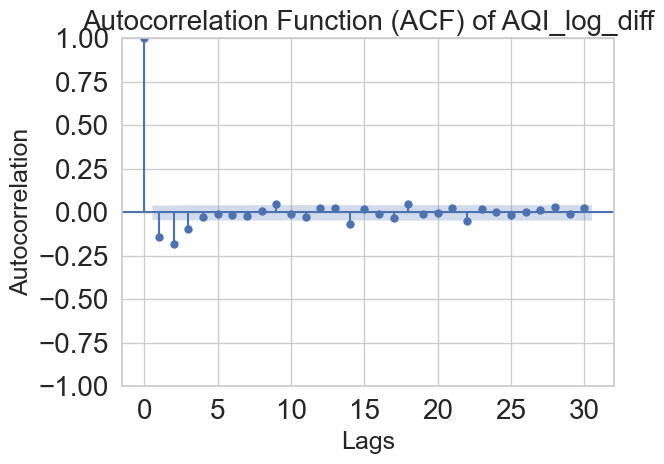

In [184]:
# Drop NaN introduced by differencing
aqi_log_diff = df['AQI_log_diff'].dropna()

# ACF Plot of AQI_log_diff
plt.figure(figsize=(12, 6))
plot_acf(aqi_log_diff, lags=30, alpha=0.05)
plt.title('Autocorrelation Function (ACF) of AQI_log_diff', fontsize=20)
plt.xlabel('Lags', fontsize=18)
plt.xticks(fontsize=20)
plt.ylabel('Autocorrelation', fontsize=18)
plt.yticks(fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()

## **Step10: Model Selection and Fitting**

Since the AQI_log_diff series is stationary, it is suitable for model fitting. We consider an ARIMA(0,0,q) model because the AR (Auto-Regressive) part is zero, the differencing order is zero (as differencing has already been applied), and it follows an MA(q) process.

Alternatively, we can use the AQI_log series directly with an ARIMA(0,1,q) model. In this case, the AR part remains zero, but the differencing order is set to one, allowing the model to handle differencing internally. The MA component remains unchanged.

Using ARIMA(0,1,q) simplifies the process, as the model takes care of differencing automatically. However, since the predictions will be in the log-transformed scale, we need to invert them using the exponential function to get the forecasted AQI values on the original scale.

In [185]:
# Fit ARIMA models
from statsmodels.tsa.arima.model import ARIMA

aqi_log = df['AQI_log']

# Fit MA(2)
model_ma2 = ARIMA(aqi_log, order=(0, 1, 2))  # (p=0, d=1, q=2)
result_ma2 = model_ma2.fit()


# Fit MA(3)
model_ma3 = ARIMA(aqi_log, order=(0, 1, 3))  # (p=0, d=1, q=3)
result_ma3 = model_ma3.fit()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarnin

## **Step11: Checking AIC score**

We compare models using the AIC (Akaike Information Criterion) score — a lower AIC indicates a better-fitting model.
In our case:

MA(2) AIC: -766.13

MA(3) AIC: -813.52

Since the MA(3) model has a lower AIC, it provides a better fit to the data compared to MA(2). So, we select the MA(3) model for forecasting.

In [186]:
print("MA(2) AIC:", result_ma2.aic)
print("MA(3) AIC:", result_ma3.aic)

MA(2) AIC: -766.1279150729997
MA(3) AIC: -813.5223440844743


## **Step 12: Checking Causality and Invertibility of MA(3)**

**Causality**

For a Moving Average process like MA(3), causality is inherently satisfied. This is because an MA process is defined as a linear combination of current and past white noise terms. Hence, the output at time t depends only on current and past values not future ones. Therefore, there is no need to check causality separately for an MA(3) process. It is always causal by definition.


**Invertibility:** 

To check if the MA(3) process is invertible, we examine the roots of its characteristic polynomial (1+Q1.L+Q2.L^2+Q3.L^3) formed using the estimated MA coefficients. An MA process is invertible if all roots lie outside the unit circle (i.e., have modulus > 1). 

In our case, all root moduli are greater than 1, which confirms that the MA(3) process is invertible. So it can be expressed as an infinite AR(∞) process; meaning we can represent it as an autoregressive model with an infinite number of lags.

In [187]:
print(result_ma3.params)  # shows theta1, theta2, theta3, etc.

ma.L1    -0.284489
ma.L2    -0.276079
ma.L3    -0.153162
sigma2    0.039800
dtype: float64


In [188]:
coeffs = [-0.153162, -0.276079, -0.284489, 1]
roots = np.roots(coeffs)
print(roots)
print(np.abs(roots))  # Modulus

[-1.50014309+1.78902838j -1.50014309-1.78902838j  1.19775684+0.j        ]
[2.33474877 2.33474877 1.19775684]


## **Step13: Verifying residuals characteristics**

To validate our model, we analyze the residuals. Ideally, residuals should resemble white noise normally distributed, with constant variance and no autocorrelation.

Q-Q plot: Shows residuals are nearly normally distributed(tail parts may show some divergence).

ACF plot: No significant lags, indicating residuals are uncorrelated.

Histogram: Supports normality with a bell-shaped distribution.


These characteristics confirm that the model has captured the structure in the data well.

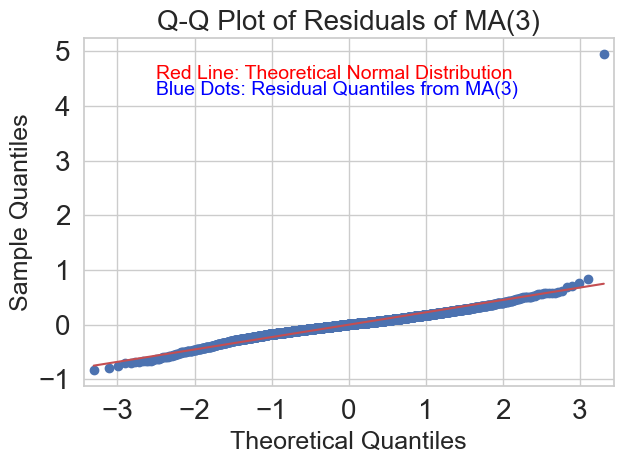

In [189]:
import statsmodels.api as sm

# Plotting residuals of MA(3)
residuals = result_ma3.resid

# Q-Q plot
fig = sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals of MA(3)', fontsize=20)
plt.xlabel('Theoretical Quantiles', fontsize=18)
plt.xticks(fontsize=20)
plt.ylabel('Sample Quantiles', fontsize=18)
plt.yticks(fontsize=20)
plt.grid(True)

# Adding annotations for red line and blue dots
plt.text(-2.5, 4.5, 'Red Line: Theoretical Normal Distribution', color='red', fontsize=14)
plt.text(-2.5, 4.2, 'Blue Dots: Residual Quantiles from MA(3)', color='blue', fontsize=14)

plt.tight_layout()
plt.show()

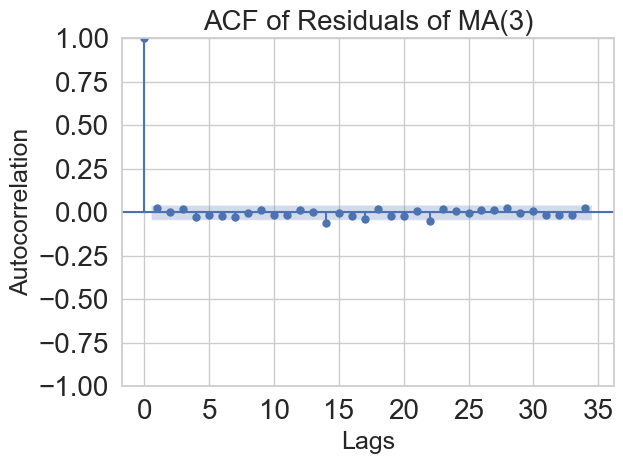

In [190]:
# ACF of residuals of MA(3)
residuals = result_ma3.resid
plot_acf(residuals)
plt.title("ACF of Residuals of MA(3)", fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Autocorrelation', fontsize=18)
plt.yticks(fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()

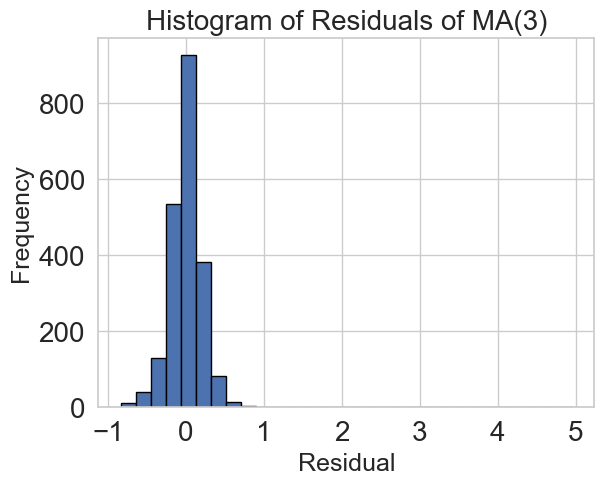

In [191]:
# Histogram of residuals of MA(3)
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Histogram of Residuals of MA(3)', fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Residual', fontsize=18)
plt.yticks(fontsize=20)
plt.ylabel('Frequency', fontsize=18)
plt.show()

## **Step14: AQI Forecast (3 Days Ahead)**

Forecasting AQI values for the next 3 days and comparing them with the actual observed values.

In [193]:
# Step 1: Forecast the next 3 steps (log scale)
forecast_log = result_ma3.forecast(steps=3)

# Step 2: Convert back to original AQI scale
forecast_original_scale = np.exp(forecast_log) - 1
forecast_original_scale = forecast_original_scale.clip(lower=0)

# Step 3: Create a DataFrame with proper datetime index
# Our last date in original AQI data is:
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=3)
forecast_df = pd.DataFrame(forecast_original_scale.values, index=future_dates, columns=['Forecasted AQI'])

# Step 4: Convert to integer
forecast_df['Forecasted AQI'] = np.floor(forecast_df['Forecasted AQI']).astype(int)

# Step 5: Insert Actual AQI values of next 3 days
actual_values = [86, 77, 65]  # Replacing with actual values 
forecast_df['Actual AQI'] = actual_values

# Step 6: View the result
forecast_df.head()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,Forecasted AQI,Actual AQI
2025-03-01 00:00:00+00:00,85,86
2025-03-02 00:00:00+00:00,80,77
2025-03-03 00:00:00+00:00,77,65
